# Implementing a GAN


Now, we will implement a GAN. To do this, we will follow the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434) to generate images of the digit 5 that resemble those in the MNIST dataset.

![dcgan](./images/dcgan.png)

DCGAN generator architecture.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
import random


/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset


Let's start by loading the MNIST dataset:


In [2]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
])
train_data = datasets.MNIST(root='./../data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./../data', train=False, transform=transform, download=True)


indices = [i for i, label in enumerate(train_data.targets) if label == 5]
# On créer un nouveau dataset avec uniquement les 5
train_data = Subset(train_data, indices)

# all_indices = list(range(len(train_data)))
# random.shuffle(all_indices)
# selected_indices = all_indices[:5000]
# train_data = Subset(train_data, selected_indices)


print("taille du dataset d'entrainement : ",len(train_data))
print("taille d'une image : ",train_data[0][0].numpy().shape) 

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

taille du dataset d'entrainement :  5421
taille d'une image :  (1, 32, 32)


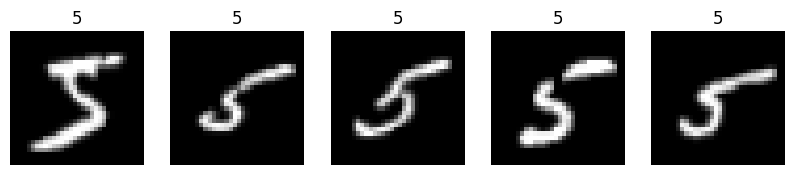

In [3]:
# Visualisons quelques images
plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_data[i][0].squeeze(), cmap='gray')
  plt.axis('off')
  plt.title(train_data[i][1])

## Creating Our Model


Now we can implement our two models. Let's start by looking at the architectural specifics described in the paper.

![dcgan_arch](./images/dcgan_arch.png)

Based on this information and the figure in the paper (see earlier in the notebook), we can build our generator model. Since we are working with $28 \times 28$ images instead of $64 \times 64$ as in the paper, we will use a more compact architecture.

**Note**: In the paper, the authors mention using *fractional-strided convolutions*. These are actually transposed convolutions, and the term *fractional-strided convolutions* is no longer commonly used today.


In [4]:
def convT_bn_relu(in_channels, out_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding,bias=False),
    nn.BatchNorm2d(out_channels),
    nn.ReLU()
  )

class generator(nn.Module):
  def __init__(self, z_dim=100,features_g=64):
    super(generator, self).__init__()
    self.gen = nn.Sequential(
      convT_bn_relu(z_dim, features_g*8, kernel_size=4, stride=1, padding=0),
      convT_bn_relu(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),
      convT_bn_relu(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),
      nn.ConvTranspose2d(features_g*2, 1, kernel_size=4, stride=2, padding=1),
      nn.Tanh()
    )
  def forward(self, x):
    return self.gen(x)
  
z= torch.randn(64,100,1,1)
gen = generator()
img = gen(z)
print(img.shape)

torch.Size([64, 1, 32, 32])


The paper does not directly describe the architecture of the discriminator. We will generally reuse the architecture of the generator but in reverse.


In [5]:
def conv_bn_lrelu(in_channels, out_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,bias=False),
    nn.BatchNorm2d(out_channels),
    nn.LeakyReLU()
  )

class discriminator(nn.Module):
  def __init__(self, features_d=64) -> None:
    super().__init__()
    self.discr = nn.Sequential(
      conv_bn_lrelu(1, features_d, kernel_size=3, stride=2, padding=1),
      conv_bn_lrelu(features_d, features_d*2, kernel_size=3, stride=2, padding=1),
      conv_bn_lrelu(features_d*2, features_d*4, kernel_size=3, stride=2, padding=1),
      nn.Conv2d(256, 1, kernel_size=3, stride=2, padding=0),
      nn.Sigmoid()
    )
    
  def forward(self, x):
    return self.discr(x)
dummy = torch.randn(64,1,32,32)
disc = discriminator()
out = disc(dummy)
print(out.shape)


torch.Size([64, 1, 1, 1])


## Model Training


It's time to get serious. The training loop of a GAN is much more complex than the training loops of the models we've seen so far.
Let's start by defining our training hyperparameters and initializing our models:


In [6]:
epochs = 50
lr=0.001
z_dim = 100
features_d = 64
features_g = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen = generator(z_dim, features_g).to(device)
disc = discriminator(features_d).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=lr)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr*0.05)
criterion = nn.BCELoss()


We will also create a *fixed_noise* to visually evaluate our model at each training step.


In [7]:
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

Before building our training loop, let's recap the steps we need to take:
- We start by retrieving *batch_size* elements from the training dataset and predicting the labels with our discriminator
- Then, we generate *batch_size* elements with our generator and predict the labels
- Next, we update the weights of the discriminator model based on the two *loss* values
- Then, we predict the labels of the generated data again (since we updated the discriminator in the meantime)
- Based on these values, we calculate the *loss* and update our generator


In [8]:
all_fake_images = []
for epoch in range(epochs):
  lossD_epoch = 0
  lossG_epoch = 0
  for real_images,_ in train_loader:
    real_images=real_images.to(device)
    pred_real = disc(real_images).view(-1)
    lossD_real = criterion(pred_real, torch.ones_like(pred_real)) # Les labels sont 1 pour les vraies images
    
    batch_size = real_images.shape[0]
    input_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
    fake_images = gen(input_noise)
    pred_fake = disc(fake_images.detach()).view(-1)
    lossD_fake = criterion(pred_fake, torch.zeros_like(pred_fake)) # Les labels sont 0 pour les fausses images

    lossD=lossD_real + lossD_fake
    lossD_epoch += lossD.item()
    disc.zero_grad()
    lossD.backward()
    opt_disc.step()
    
    # On refait l'inférence pour les images générées (avec le discriminateur mis à jour)
    pred_fake = disc(fake_images).view(-1)
    lossG=criterion(pred_fake, torch.ones_like(pred_fake)) # On veut que le générateur trompe le discriminateur donc on veut que les labels soient 1
    lossG_epoch += lossG.item()
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()
    
  # On génère des images avec le générateur
  if epoch % 10 == 0 or epoch==0:
    print(f"Epoch [{epoch}/{epochs}] Loss D: {lossD_epoch/len(train_loader):.4f}, loss G: {lossG_epoch/len(train_loader):.4f}")
    gen.eval()
    fake_images = gen(fixed_noise)
    all_fake_images.append(fake_images)
    #cv2.imwrite(f"gen/image_base_gan_{epoch}.png", fake_images[0].squeeze().detach().cpu().numpy()*255.0)
    gen.train()
    

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Epoch [0/50] Loss D: 0.4726, loss G: 2.0295
Epoch [10/50] Loss D: 0.1126, loss G: 3.6336
Epoch [20/50] Loss D: 0.0767, loss G: 4.0642
Epoch [30/50] Loss D: 0.0571, loss G: 4.5766
Epoch [40/50] Loss D: 0.0178, loss G: 5.3689


Let's visualize the images generated during training.


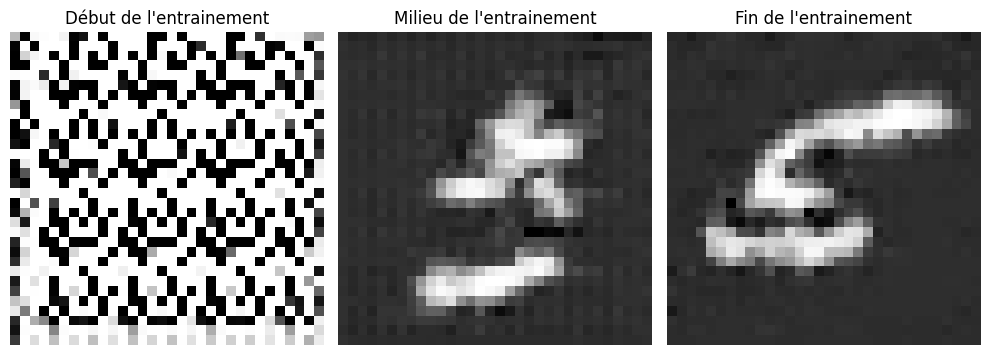

In [36]:
index=0
image_begin = all_fake_images[0][index]
image_mid = all_fake_images[len(all_fake_images)//2][index]
image_end = all_fake_images[-1][index]

# Création de la figure
plt.figure(figsize=(10, 5))

# Affichage de l'image du début de l'entraînement
plt.subplot(1, 3, 1)
plt.imshow(image_begin.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Début de l'entrainement")

# Affichage de l'image du milieu de l'entraînement
plt.subplot(1, 3, 2)
plt.imshow(image_mid.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Milieu de l'entrainement")

# Affichage de l'image de la fin de l'entraînement
plt.subplot(1, 3, 3)
plt.imshow(image_end.squeeze().detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Fin de l'entrainement")

# Affichage de la figure
plt.tight_layout()
plt.show()

We can see that our generator is now capable of generating digits that vaguely resemble the number 5.
If you're feeling brave, you can try improving the model and training it on all the digits in MNIST, for example.
Another good exercise is to implement a *conditional* GAN.
